Project:

The objective of the project is to build a Machine Learning model to classify a picture of a hand among different sign language characters. The process described in this Jupyter notebook is as follows:

1. First simulation of a model under a defined architecture of the neural network and values of the hyperparameters
2. Second simulation by changing the architecture of the CNN, but with a set of fixed parameters
3. Hyperparameter tunning for the second model using Bayesian optimization

This process will show the evolution of the precision of the Machine Learning model by seeing the efects of the Hyperparameters and the layers configuration of the model. Since this is an image classification problem, the solution involves training a Convolutional Neural Network.

General loading and visualization of the dataset

In [1]:
#Libraries imports
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd

In [2]:
#First, we define the paths of the data downloaded from Kaggle (https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
train_csv_path = 'data/sign_mnist_train.csv'
test_csv_path = 'data/sign_mnist_test.csv'

In [3]:
#First we will load one dataset and see the structure
data = pd.read_csv(train_csv_path)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
#And now we define a load function that puts the information in variables
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    labels = data['label'].values
    images = data.drop(columns=['label']).values
    images = images.reshape(-1, 28, 28)
    return images, labels

In [5]:
# And now load the information
train_images, train_labels = load_data(train_csv_path)
test_images, test_labels = load_data(test_csv_path)

Missing label: 9 (J) nor 25 (Z) according to the definition from  https://www.kaggle.com/datasets/datamunge/sign-language-mnist?resource=download

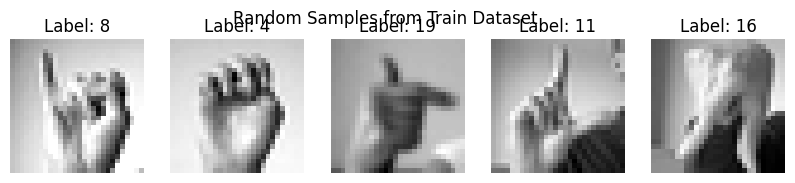

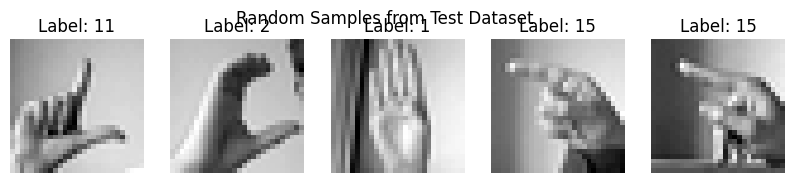

In [6]:
#Now we will visualize some of the available data
def visualize_random_images(images, labels, num_images=5, dataset_name="Train"):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f"Label: {labels[index]}")
        plt.axis('off')
    plt.suptitle(f"Random Samples from {dataset_name} Dataset")
    plt.show()

#5 from the train dataset
visualize_random_images(train_images, train_labels, num_images=5, dataset_name="Train")


visualize_random_images(test_images, test_labels, num_images=5, dataset_name="Test")

In [7]:
#Definition of the class for the dataset
class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype('float32')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
# Transformation for the normalization of the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creation of the train and test datasets
train_dataset = SignLanguageDataset(train_images, train_labels, transform=transform)
test_dataset = SignLanguageDataset(test_images, test_labels, transform=transform)

#Now I divide the train dataset into a training and validation dataset using a random split, 20% for the validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#Creation of dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


1. Training of the first CNN with fixed hyperparameters

In [9]:
#Model architecture definition
class SignLanguageCNN_1(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) 
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
#Creation of the model
num_classes = 25 # I fixed the value because there is no data for classification 9
model_1 = SignLanguageCNN_1(num_classes)

# Optimizer definition and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [11]:
# Model training
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader: #loads images and labels in batches (batch size = 32). It goes through all the train dataset
            optimizer.zero_grad()
            outputs = model(images) #predictions
            loss = criterion(outputs, labels) #calculate loss
            loss.backward() #computes gradients of the loss with respect to the parameters
            optimizer.step() #update model's parameters
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

train_model(model_1, train_loader, val_loader)

Epoch 1/10, Loss: 1.0909698549017521
Validation Loss: 0.055330024115730424, Accuracy: 98.37916590784921%
Epoch 2/10, Loss: 0.03175165186434668
Validation Loss: 0.001124634076869941, Accuracy: 100.0%
Epoch 3/10, Loss: 0.0005322399082306988
Validation Loss: 0.0006069235677873515, Accuracy: 100.0%
Epoch 4/10, Loss: 0.00022978127652616885
Validation Loss: 0.000356661651589685, Accuracy: 100.0%
Epoch 5/10, Loss: 0.0001274523864643795
Validation Loss: 0.00027858058877501567, Accuracy: 100.0%
Epoch 6/10, Loss: 7.456383972834403e-05
Validation Loss: 0.00023280180320012353, Accuracy: 100.0%
Epoch 7/10, Loss: 5.095941544431426e-05
Validation Loss: 0.00015918992428105624, Accuracy: 100.0%
Epoch 8/10, Loss: 2.8699411932645093e-05
Validation Loss: 0.00011245494893826215, Accuracy: 100.0%
Epoch 9/10, Loss: 1.8866502678484116e-05
Validation Loss: 7.881908960717569e-05, Accuracy: 100.0%
Epoch 10/10, Loss: 1.2832310719599717e-05
Validation Loss: 5.661497904804682e-05, Accuracy: 100.0%


In [12]:
#Now we evaluate the accuracy on the test set:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

evaluate_model(model_1, test_loader)

Test Accuracy: 86.48912437255996%


2. Change in the architecture of the CNN

In [13]:
# New CNN architecture adding Dropout layers and another fully connected layer
class SignLanguageCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 60)
        self.fc3 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
#Creation of the second model
num_classes = 25 # I fixed the value because there is no data for classification 9
model_2 = SignLanguageCNN_2(num_classes)

# Optimizer definition and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [15]:
# Train the second model
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

train_model(model_2, train_loader, val_loader)

Epoch 1/10, Loss: 1.8848406326302274
Validation Loss: 0.44514797047473664, Accuracy: 86.37770897832817%
Epoch 2/10, Loss: 0.7418985379618501
Validation Loss: 0.14068509298268445, Accuracy: 97.30468038608632%
Epoch 3/10, Loss: 0.46080886916388936
Validation Loss: 0.06838186294230264, Accuracy: 99.56292114368968%
Epoch 4/10, Loss: 0.35428759981125724
Validation Loss: 0.03530976857426901, Accuracy: 99.56292114368968%
Epoch 5/10, Loss: 0.271778955638105
Validation Loss: 0.012098250009436269, Accuracy: 99.85430704789655%
Epoch 6/10, Loss: 0.23328716511291817
Validation Loss: 0.006873415349620573, Accuracy: 100.0%
Epoch 7/10, Loss: 0.2086764161456024
Validation Loss: 0.018518033262807876, Accuracy: 99.6357676197414%
Epoch 8/10, Loss: 0.19006373793065678
Validation Loss: 0.007216397037683596, Accuracy: 99.94536514296121%
Epoch 9/10, Loss: 0.16333698307443953
Validation Loss: 0.004005193860224566, Accuracy: 99.94536514296121%
Epoch 10/10, Loss: 0.15797258177156198
Validation Loss: 0.0022313710

In [16]:
#Now we evaluate the accuracy on the test set:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

evaluate_model(model_2, test_loader)

Test Accuracy: 93.20970440602342%


3. Hyperparameter tunning for the second model.

In [21]:
# Definition of the architecture but with parametrized variables
class SignLanguageCNN_2_param(nn.Module):
    def __init__(self, num_classes, conv1_filters=32, conv2_filters=64, kernel_size=3, pool_kernel_size=2,
                 fc1_units=128, fc2_units=60, dropout_rate=0.4):
        super(SignLanguageCNN_2_param, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=kernel_size, stride=1, padding=1)

        # Pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

        self.flattened_size = None

        # Fully connected layers
        self.fc1 = nn.Linear(1, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, num_classes)

    def forward(self, x):

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)

        if self.flattened_size is None:
            self.flattened_size = x.size(1) * x.size(2) * x.size(3)
            self.fc1 = nn.Linear(self.flattened_size, self.fc1.out_features).to(x.device)

        x = x.view(-1, self.flattened_size) 
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate_model(model, train_loader, val_loader, epochs=10, lr=0.001, device="cpu"):
    # Device CPU or GPU
    model.to(device)

    # Definition of loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training phase
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) 

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device) 
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}%")

    # Returns the accuracy
    return accuracy

In [ ]:
# Iterations counter
global_iteration = 0

def objective_function(params, train_loader, val_loader, device="cpu"):

    global global_iteration
    global_iteration += 1

    print(f"Evaluación {global_iteration}/100")


    num_classes = 25
    conv1_filters = int(params['conv1_filters'])
    conv2_filters = int(params['conv2_filters'])
    kernel_size = int(params['kernel_size'])
    pool_kernel_size = int(params['pool_kernel_size'])
    fc1_units = int(params['fc1_units'])
    fc2_units = int(params['fc2_units'])
    dropout_rate = params['dropout_rate']

    # Model creation
    model = SignLanguageCNN_2_param(
        num_classes=num_classes,
        conv1_filters=conv1_filters,
        conv2_filters=conv2_filters,
        kernel_size=kernel_size,
        pool_kernel_size=pool_kernel_size,
        fc1_units=fc1_units,
        fc2_units=fc2_units,
        dropout_rate=dropout_rate
    )

    # Training and evaluation
    accuracy = train_and_evaluate_model(model, train_loader, val_loader, epochs=10, lr=0.001, device=device)

    return -accuracy

In [ ]:
# Definition of the range for the parameters
space = [
    Integer(16, 64, name='conv1_filters'),          # Conv 1 filter
    Integer(32, 128, name='conv2_filters'),         # Conv 2 filter
    Integer(3, 5, name='kernel_size'),              # Kernel size
    Integer(2, 3, name='pool_kernel_size'),         # Pooling size
    Integer(64, 512, name='fc1_units'),             # Fully connected 1 units
    Integer(32, 256, name='fc2_units'),             # Fully connected 2 units
    Real(0.2, 0.5, name='dropout_rate')             # Dropout rate
]

# Bayesian optimization
result = gp_minimize(
    func=lambda params: objective_function(
        dict(zip(['conv1_filters', 'conv2_filters', 'kernel_size', 'pool_kernel_size', 'fc1_units', 'fc2_units', 'dropout_rate'], params)),
        train_loader=train_loader,
        val_loader=val_loader,
        device="cuda"  # "cpu" or "cuda"
    ),
    dimensions=space,
    n_calls=100,  # Evaluations number
    random_state=42
)

# Results
best_params = dict(zip(
    ['conv1_filters', 'conv2_filters', 'kernel_size', 'pool_kernel_size', 'fc1_units', 'fc2_units', 'dropout_rate'],
    result.x
))
print("Mejores Hiperparámetros:", best_params)



Evaluación 1/100
Epoch 1/10, Loss: 2.8234944045109867
Validation Loss: 2.2573786079883575, Accuracy: 29.448187943908213%
Epoch 2/10, Loss: 2.1449749386466745
Validation Loss: 1.6861960014631583, Accuracy: 47.42305590967037%
Epoch 3/10, Loss: 1.8896586648588445
Validation Loss: 1.4598090939743573, Accuracy: 54.325259515570934%
Epoch 4/10, Loss: 1.730366899977605
Validation Loss: 1.3610789450102074, Accuracy: 57.366599890730285%
Epoch 5/10, Loss: 1.6321330887782002
Validation Loss: 1.2990645443977311, Accuracy: 57.6761974139501%
Epoch 6/10, Loss: 1.5543875359378354
Validation Loss: 1.0694571542878484, Accuracy: 65.72573301766528%
Epoch 7/10, Loss: 1.5105710828668686
Validation Loss: 1.1279140177161195, Accuracy: 63.030413403751595%
Epoch 8/10, Loss: 1.4522932282875372
Validation Loss: 1.001924572988998, Accuracy: 67.74722272810052%
Epoch 9/10, Loss: 1.431317778133409
Validation Loss: 0.9324217826821083, Accuracy: 72.68257148060462%
Epoch 10/10, Loss: 1.370571975798239
Validation Loss: 1.

In [ ]:
best_params

{'conv1_filters': 23,
 'conv2_filters': 91,
 'kernel_size': 4,
 'pool_kernel_size': 2,
 'fc1_units': 368,
 'fc2_units': 256,
 'dropout_rate': 0.2}

Now, considering the optimal Hyperparameters, we have to train the model with those parameters.

In [17]:
#Best parameters obtained from the Hyperparameter tunning
best_params={'conv1_filters': 23,
 'conv2_filters': 91,
 'kernel_size': 4,
 'pool_kernel_size': 2,
 'fc1_units': 368,
 'fc2_units': 256,
 'dropout_rate': 0.2}

In [19]:
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001, device="cpu"):

    model.to(device)

    # Loss function and optimizer definition
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader)}")

        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}%")

    # Final evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}%")

    return test_accuracy


In [23]:
# Initialization using the best Hyperparameters
best_model = SignLanguageCNN_2_param(
    num_classes=25,
    conv1_filters=int(best_params['conv1_filters']),
    conv2_filters=int(best_params['conv2_filters']),
    kernel_size=int(best_params['kernel_size']),
    pool_kernel_size=int(best_params['pool_kernel_size']),
    fc1_units=int(best_params['fc1_units']),
    fc2_units=int(best_params['fc2_units']),
    dropout_rate=best_params['dropout_rate']
)

# Model training and evaluation
test_accuracy = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=10, 
    lr=0.001,
    device="cpu"
)

print(f"Final Test Accuracy: {test_accuracy}%")

Epoch 1/10, Training Loss: 1.1163751427870476
Validation Loss: 0.13222491128240213, Accuracy: 96.75833181569841%
Epoch 2/10, Training Loss: 0.2712583706010637
Validation Loss: 0.037244723053908975, Accuracy: 99.14405390639227%
Epoch 3/10, Training Loss: 0.15293070696175012
Validation Loss: 0.012168347366495318, Accuracy: 99.94536514296121%
Epoch 4/10, Training Loss: 0.1189906323766485
Validation Loss: 0.0054204230072236684, Accuracy: 99.87251866690949%
Epoch 5/10, Training Loss: 0.10282844726573757
Validation Loss: 0.008621238848887557, Accuracy: 99.85430704789655%
Epoch 6/10, Training Loss: 0.09115332496541266
Validation Loss: 0.0033074484111471807, Accuracy: 99.98178838098707%
Epoch 7/10, Training Loss: 0.0788757197791541
Validation Loss: 0.002152884944946489, Accuracy: 99.90894190493535%
Epoch 8/10, Training Loss: 0.07852413527141536
Validation Loss: 0.007411954697577024, Accuracy: 99.7632489528319%
Epoch 9/10, Training Loss: 0.06986750421410536
Validation Loss: 0.004928060167426444